https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

https://www.kaggle.com/code/faressayah/lending-club-loan-defaulters-prediction/comments

https://www.kaggle.com/code/mgmarques/wines-type-and-quality-classification-exercises#notebook-container

https://www.kaggle.com/code/vishalyo990/prediction-of-quality-of-wine

# Data Preparation

In [292]:
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from scipy.stats import skew, norm, probplot, boxcox, f_oneway

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score, precision_score,recall_score
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import learning_curve, KFold


## Load Dataset

In [3]:
df = pd.read_csv('winequalityN.csv')

In [4]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


Text(0.5, 1.0, 'White Wine')

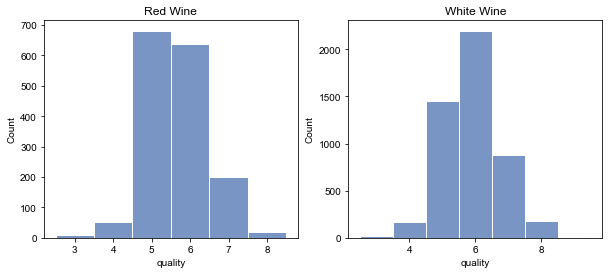

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))
sns.set(style="darkgrid")
sns.histplot(data=df[df['type']=='red'], x="quality", discrete=True, ax=axs[0])
sns.histplot(data=df[df['type']=='white'], x="quality", discrete=True, ax=axs[1])
axs[0].set_title('Red Wine')
axs[1].set_title('White Wine')

In [6]:
red_quality_75th = np.quantile(df[df['type']=='red']['quality'], 0.75)
print(red_quality_75th)

white_quality_75th = np.quantile(df[df['type']=='white']['quality'], 0.75)
print(white_quality_75th)

6.0
6.0


In [7]:
df_red = df[df['type']=='red'].reset_index(drop=True)
df_white = df[df['type']=='white'].reset_index(drop=True)

In [8]:
df_red['target'] = df_red['quality'].apply(lambda x : 1 if x >= 6 else 0)
df_white['target'] = df_white['quality'].apply(lambda x : 1 if x >= 6 else 0)

In [9]:
df_red.groupby('target')['type'].count()

target
0    744
1    855
Name: type, dtype: int64

In [10]:
df_white.groupby('target')['type'].count()

target
0    1640
1    3258
Name: type, dtype: int64

Since red wine and white wine has different distribution in wine quality, we decide to select red wine as the targeted type for the purpose of this analysis as red wine data is more balanced than white wine.

In [11]:
df_red = df_red.drop(['type', 'quality'], axis=1)

In [60]:
X_cols = [x for x in cols if x!= 'target']
print(X_cols)

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


## Exploratory Data Analysis

In [12]:
df_red.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,target
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


In [13]:
def data_check(df):
    data_types = df.dtypes
    nrows = df.shape[0]
    nnulls = df.isnull().sum()
    null_ratio = nnulls/nrows * 100
    skewness = df.skew()
    
    out = pd.concat([data_types, nnulls, null_ratio, skewness], axis = 1)
    out.columns = ['dtypes', 'num_nulls', 'null_ratio_pct', 'skewness']
    return out

In [30]:
data_check_out = data_check(df_red)
data_check_out

,dtypes,num_nulls,null_ratio_pct,skewness
fixed acidity,float64,0,0.0,0.980441
volatile acidity,float64,0,0.0,0.673387
citric acid,float64,0,0.0,0.313999
residual sugar,float64,0,0.0,4.537260
chlorides,float64,0,0.0,5.674939
free sulfur dioxide,float64,0,0.0,1.256757
total sulfur dioxide,float64,0,0.0,1.516609
density,float64,0,0.0,0.066754
pH,float64,0,0.0,0.197771
sulphates,float64,0,0.0,2.432711


### Nulls Cleaning

Since the number of nulls is small, drop na. Dropping 4 obs from 1 category and 2 obs from 0 category.


In [15]:
print("Before dropping NA: ", df_red.target.value_counts())
df_red = df_red.dropna()
print('After dropping NA: ', df_red.target.value_counts())

Before dropping NA:  1    855
0    744
Name: target, dtype: int64
After dropping NA:  1    851
0    742
Name: target, dtype: int64


### Correlation

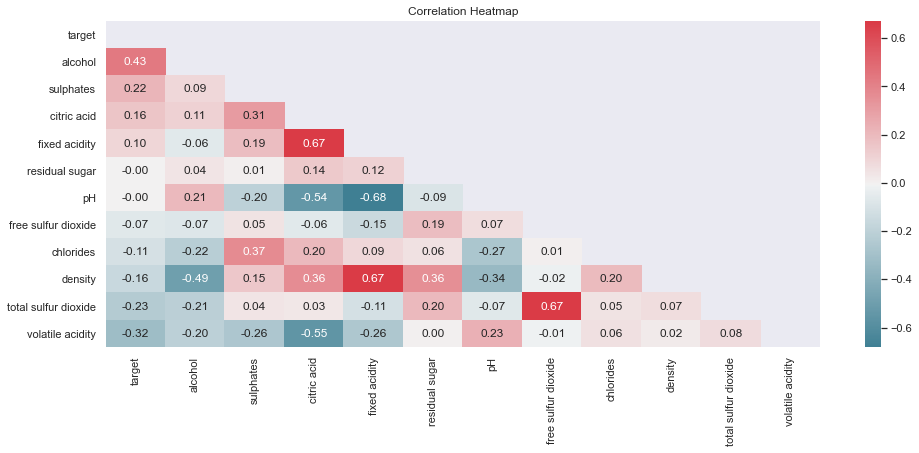

In [16]:
plt.figure(figsize=(16, 6))
corr = df_red.corr()
top_corr_cols = corr.target.sort_values(ascending=False).keys()
top_corr = corr.loc[top_corr_cols, top_corr_cols]
dropSelf = np.zeros_like(top_corr)
dropSelf[np.triu_indices_from(dropSelf)] = True
heatmap = sns.heatmap(top_corr, cmap=sns.diverging_palette(220, 10, as_cmap=True), annot=True, fmt=".2f", mask=dropSelf)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap')
sns.set(font_scale=1)
del corr, dropSelf, top_corr

In [17]:
print(len(df_red.columns))
cols = df_red.columns

12


### Check Distribution

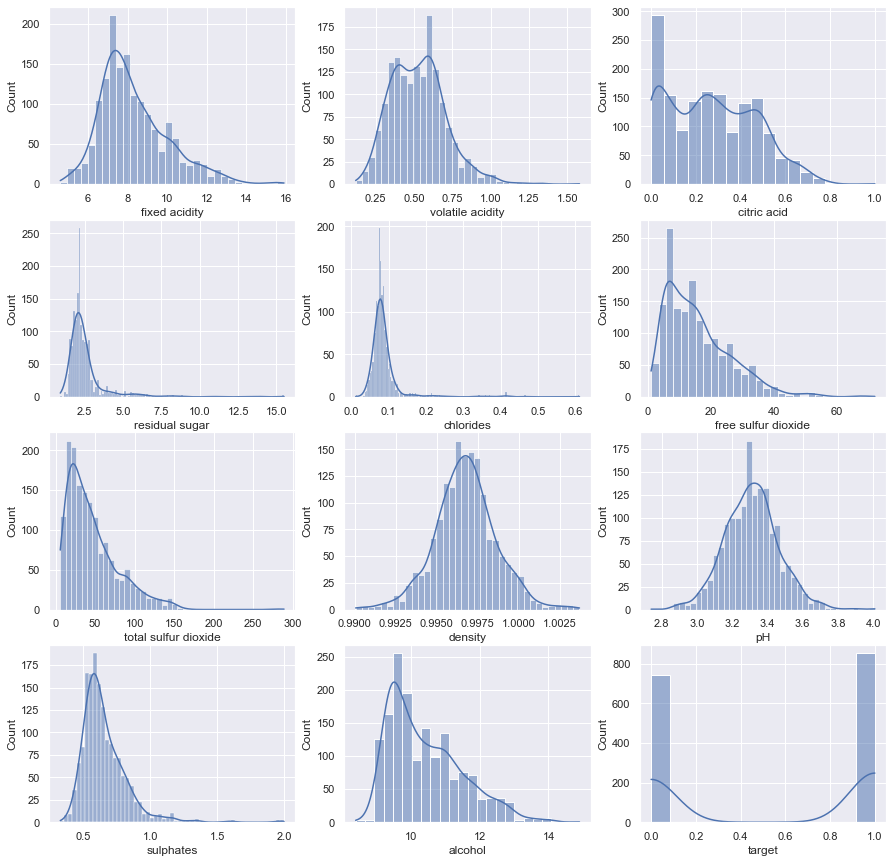

In [18]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i in range(4):
    for j in range(3):
        sns.histplot(df_red[cols[i*3+j]], ax = axs[i,j], kde=True)

In [34]:
# Box Cox
high_skew_data = data_check_out['skewness'].sort_values()[-5:]
high_skew_data

free sulfur dioxide     1.256757
total sulfur dioxide    1.516609
sulphates               2.432711
residual sugar          4.537260
chlorides               5.674939
Name: skewness, dtype: float64

In [36]:
l_opt = {}
for col in high_skew_data.index:
    df_red[col], l_opt[col] = boxcox(df_red[col]+1)

In [38]:
# Skewness after boxcox transform
df_red[high_skew_data.index].skew()

free sulfur dioxide    -0.009938
total sulfur dioxide   -0.003751
sulphates               0.010672
residual sugar         -0.015143
chlorides              -0.151989
dtype: float64

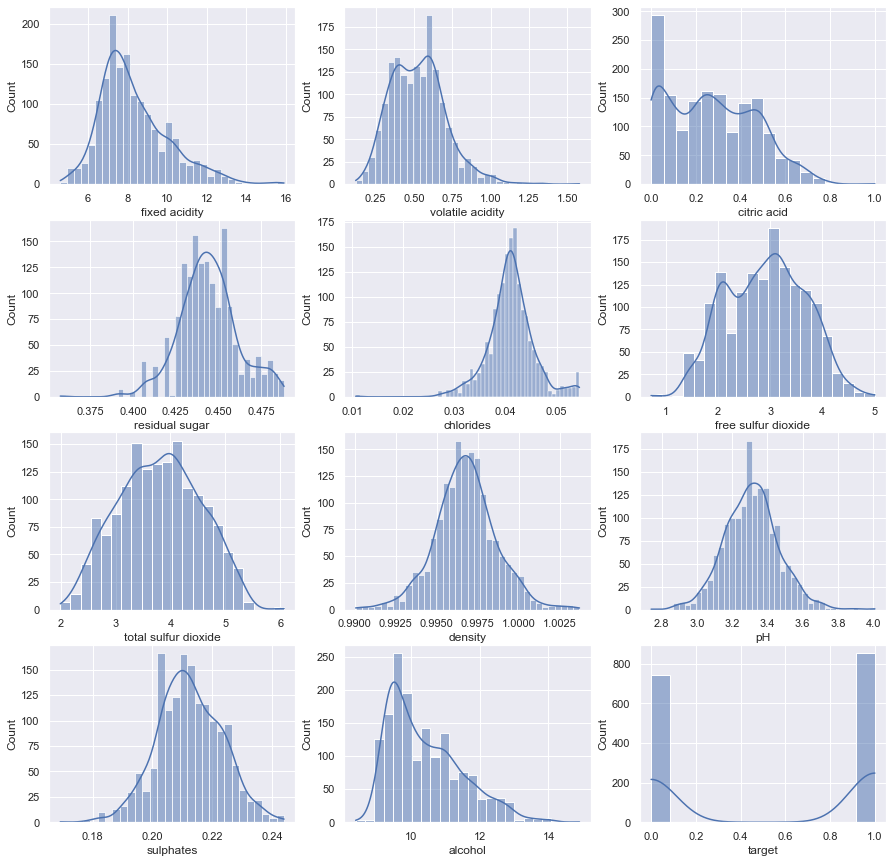

In [39]:
fig, axs = plt.subplots(4, 3, figsize=(15, 15))
for i in range(4):
    for j in range(3):
        sns.histplot(df_red[cols[i*3+j]], ax = axs[i,j], kde=True)

In [63]:
scaler = StandardScaler(with_std = False)
df_red_std = pd.DataFrame(scaler.fit_transform(df_red[X_cols]), columns= X_cols) 

### Check Multicolinearity

In [64]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
# the independent variables set

def calc_VIF(df, X_cols):

    X = df[X_cols]

    # VIF dataframe
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns

    # calculating VIF for each feature
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                              for i in range(len(X.columns))]

    return vif_data.sort_values('VIF')

In [65]:
vif = calc_VIF(df_red_std, X_cols)
print(vif)

                 feature       VIF
9              sulphates  1.363095
4              chlorides  1.413092
1       volatile acidity  1.747213
3         residual sugar  1.962985
5    free sulfur dioxide  2.821226
2            citric acid  2.876660
8                     pH  3.076150
6   total sulfur dioxide  3.083536
10               alcohol  3.467447
0          fixed acidity  7.139007
7                density  7.435760


In [66]:
X_cols_clean = [x for x in X_cols if x not in ['density', 'fixed acidity']]

In [67]:
vif = calc_VIF(df_red_std, X_cols_clean)

In [68]:
print(vif)

                feature       VIF
2        residual sugar  1.144592
7             sulphates  1.239332
3             chlorides  1.350372
8               alcohol  1.421663
6                    pH  1.618155
0      volatile acidity  1.684725
1           citric acid  2.237627
4   free sulfur dioxide  2.791218
5  total sulfur dioxide  2.943417


# Modeling

- Decision trees with some form of pruning
- Neural networks
- Boosting
- Support Vector Machines
- k-nearest neighbors

## Train Test Split

In [70]:
X_train, X_test, y_train, y_test = train_test_split(df_red_std[X_cols], df_red['target'], test_size=0.3, random_state=0)

In [313]:
X = df_red_std[X_cols]
y = df_red['target']

## Decision Tree Classifier

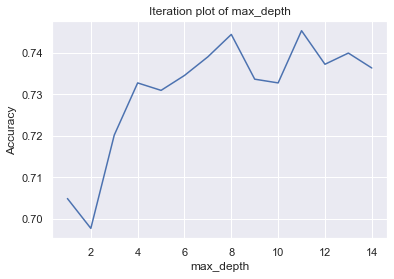

In [192]:
# Hyper-parameter Tuning
# max_depth
avg_acc_list = []
train_score_list = []
for i in range(1,15):
    dt = DecisionTreeClassifier(random_state=0, max_depth = i)
    avg_acc_list.append(np.mean(cross_val_score(dt, X_train, y_train, cv=5)))
    train_score_list.append(dt.fit(X_train, y_train).score(X_train, y_train))
    
plt.plot([i for i in range(1,15)], avg_acc_list)
# plt.plot([i for i in range(1,15)], train_score_list)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title('Iteration plot of max_depth')
plt.show()

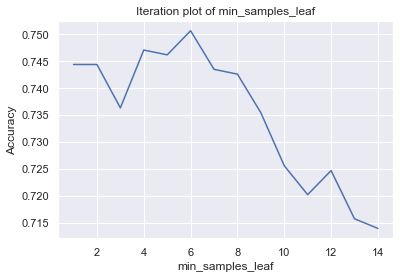

In [193]:
# min_samples_leaf
avg_acc_list = []
train_score_list = []
for i in range(1,15):
    dt = DecisionTreeClassifier(random_state=0, min_samples_leaf = i, max_depth=8)
    avg_acc_list.append(np.mean(cross_val_score(dt, X_train, y_train, cv=5)))
    train_score_list.append(dt.fit(X_train, y_train).score(X_train, y_train))
    
fig = plt.figure()
plt.plot([i for i in range(1,15)], avg_acc_list)
# plt.plot([i for i in range(1,15)], train_score_list)
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.title('Iteration plot of min_samples_leaf')
plt.show()

In [283]:
%%time
dt = DecisionTreeClassifier(random_state=0, max_depth=8, min_samples_leaf=6)
np.mean(cross_val_score(dt, X_train, y_train, cv=5))
# cross_validate(dt, X_train, y_train, cv=5, scoring=['accuracy', 'roc_auc'])

CPU times: user 53.2 ms, sys: 6.38 ms, total: 59.6 ms
Wall time: 57.4 ms


0.7506726457399104

In [275]:
%%time
out = dt.predict(X_test)

CPU times: user 3.65 ms, sys: 2.1 ms, total: 5.76 ms
Wall time: 6.36 ms


In [309]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    
#     fig = plt.figure()
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )

#     permutation = np.random.permutation(len(X))
#     X = X.iloc[permutation]
#     y = y.iloc[permutation]
    
    # plotting learning curve
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)
    
    plt.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    
    plt.fill_between(
            train_sizes,
            test_scores_mean - test_scores_std,
            test_scores_mean + test_scores_std,
            alpha=0.1,
            color="g",
        )
    plt.plot(
            train_sizes, train_scores_mean, "o-", color="r", label="Training score"
        )
    plt.plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    plt.legend(loc="best")
    
    plt.grid()
    
    return plt
    

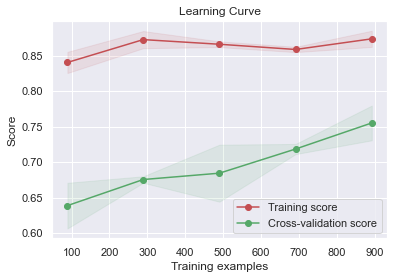

In [327]:
title = 'Learning Curve'
plot = plot_learning_curve(
    dt,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=KFold(n_splits=5, shuffle=True),
    n_jobs=None,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

## Neural Network

In [108]:
%%time
mlp = MLPClassifier(random_state = 0)
mlp.fit(X_train, y_train)
# np.mean(cross_val_score(mlp, X_train, y_train, cv=5))

CPU times: user 3.64 s, sys: 998 ms, total: 4.64 s
Wall time: 717 ms


MLPClassifier(random_state=0)

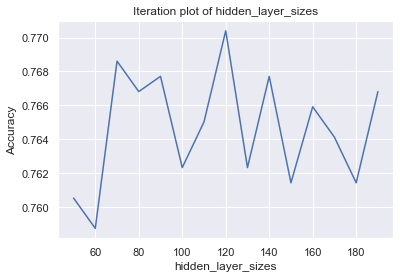

CPU times: user 4min 43s, sys: 1min 3s, total: 5min 47s
Wall time: 48 s


In [132]:
%%time
# hidden_layer_sizes
avg_acc_list = []
# fig = plt.figure(figsize=(10,8))
for i in range(50, 200, 10):

    mlp = MLPClassifier(random_state = 0, hidden_layer_sizes = i)
    mlp.fit(X_train, y_train)
#     plt.plot([x for x in range(len(mlp.loss_curve_))], mlp.loss_curve_, label = 'hidden_layer_size_'+str(i))
    avg_acc_list.append(np.mean(cross_val_score(mlp, X_train, y_train, cv=5)))
    
plt.plot([i for i in range(50, 200, 10)], avg_acc_list)
plt.xlabel("hidden_layer_sizes")
plt.ylabel("Accuracy")
plt.title('Iteration plot of hidden_layer_sizes')
# fig.legend(loc='upper right')
plt.show()

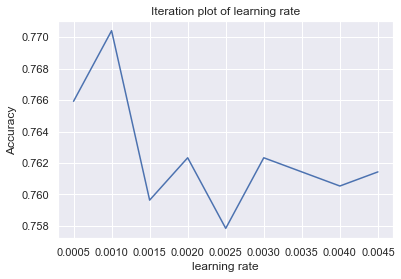

In [135]:
# learning_rate
avg_acc_list = []
for i in range(1, 10):
    mlp = MLPClassifier(random_state = 0, learning_rate_init = i*5/10000, hidden_layer_sizes=120)
    mlp.fit(X_train, y_train)
#     plt.plot([x for x in range(len(mlp.loss_curve_))], mlp.loss_curve_, label = 'learning_rate'+str(i))
    avg_acc_list.append(np.mean(cross_val_score(mlp, X_train, y_train, cv=5)))
    
plt.plot([i*5/10000 for i in range(1, 10)], avg_acc_list)
plt.xlabel("learning rate")
plt.ylabel("Accuracy")
plt.title('Iteration plot of learning rate')
# fig.legend(loc='upper right')
plt.show()

In [146]:
%%time
mlp = MLPClassifier(random_state=0, learning_rate_init=0.001, hidden_layer_sizes=120, 
                    validation_fraction=0.2)
print(np.mean(cross_val_score(mlp, X_train, y_train, cv=5)))
mlp.fit(X_train, y_train)

0.7704035874439462
CPU times: user 19.4 s, sys: 4.47 s, total: 23.8 s
Wall time: 3.35 s


MLPClassifier(hidden_layer_sizes=120, random_state=0, validation_fraction=0.2)

Text(0.5, 1.0, 'Loss Curve')

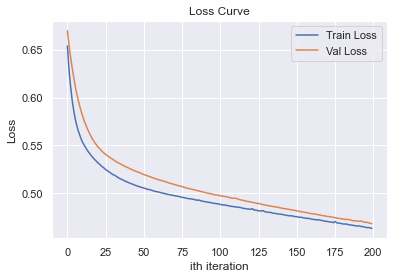

In [323]:
mlp.fit(X_train, y_train)
plt.plot(mlp.loss_curve_, label='Train Loss')
mlp.fit(X_test, y_test)
plt.plot(mlp.loss_curve_, label='Val Loss')
plt.legend()
plt.xlabel('ith iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')

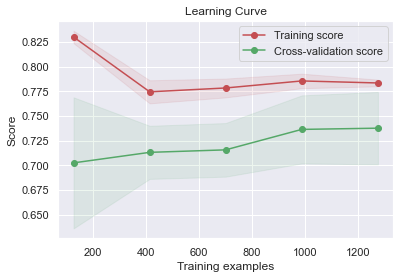

In [319]:
title = 'Learning Curve'
plot = plot_learning_curve(
    mlp,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [274]:
%%time
out = mlp.predict(X_test)

CPU times: user 11.4 ms, sys: 13.8 ms, total: 25.2 ms
Wall time: 19 ms


## Gradient Boosting

In [159]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, 
                                 max_depth=3, random_state=0)#.fit(X_train, y_train)
np.mean(cross_val_score(gbc, X_train, y_train, cv=5))

0.7820627802690583

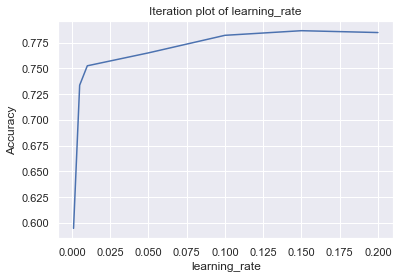

In [165]:
avg_acc_list = []
lr_list = [0.001,0.005,0.01,0.05,0.1, 0.15, 0.2]
for i in lr_list:
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=i, 
                                 max_depth=3, random_state=0)
    
    avg_acc_list.append(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)))
    
plt.plot(lr_list, avg_acc_list)
plt.xlabel("learning_rate")
plt.ylabel("Accuracy")
plt.title('Iteration plot of learning_rate')
# fig.legend(loc='upper right')
plt.show()

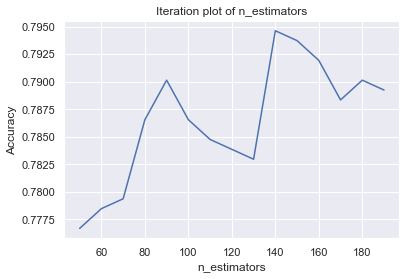

In [170]:
avg_acc_list = []
for i in range(50, 200, 10):
    gbc = GradientBoostingClassifier(n_estimators=i, learning_rate=0.15, 
                                 max_depth=3, random_state=0)
    
    avg_acc_list.append(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)))
    
plt.plot([x for x in range(50,200,10)], avg_acc_list)
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title('Iteration plot of n_estimators')
plt.show()

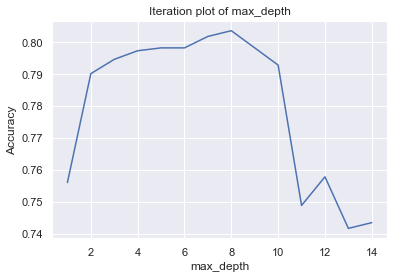

In [171]:
avg_acc_list = []
for i in range(1,15):
    gbc = GradientBoostingClassifier(n_estimators=140, learning_rate=0.15, 
                                 max_depth=i, random_state=0)
    
    avg_acc_list.append(np.mean(cross_val_score(gbc, X_train, y_train, cv=5)))
    
plt.plot([x for x in range(1,15)], avg_acc_list)
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.title('Iteration plot of max_depth')
plt.show()

In [325]:
%%time
gbc = GradientBoostingClassifier(n_estimators=140, learning_rate=0.15, 
                                 max_depth=8, random_state=0).fit(X_train, y_train)

CPU times: user 823 ms, sys: 17.9 ms, total: 841 ms
Wall time: 853 ms


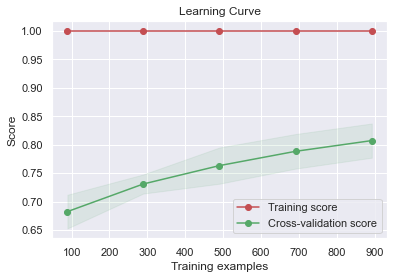

In [326]:
title = 'Learning Curve'
plot = plot_learning_curve(
    gbc,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=KFold( n_splits=5, shuffle=True),
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [276]:
%%time
out = gbc.predict(X_test)

CPU times: user 12.2 ms, sys: 1.85 ms, total: 14.1 ms
Wall time: 12.4 ms


## Support Vector Machines

In [182]:
svm = SVC(gamma='auto', kernel = 'rbf')
np.mean(cross_val_score(svm, X_train, y_train, cv=5))

0.7345291479820628

In [187]:
avg_acc_dict = {}
for k in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(gamma='auto', kernel = k)
    avg_acc_dict[k] = np.mean(cross_val_score(svm, X_train, y_train, cv=5))

In [188]:
avg_acc_dict

{'linear': 0.7408071748878924,
 'poly': 0.71390134529148,
 'rbf': 0.7345291479820628,
 'sigmoid': 0.685201793721973}

In [248]:
%%time
svm = SVC(gamma='auto', kernel = 'linear').fit(X_train, y_train)

CPU times: user 66.7 ms, sys: 6.17 ms, total: 72.9 ms
Wall time: 75.7 ms


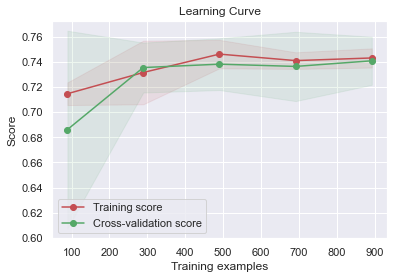

In [328]:
title = 'Learning Curve'
plot = plot_learning_curve(
    svm,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [272]:
%%time
out = svm.predict(X_test)

CPU times: user 27.6 ms, sys: 2.19 ms, total: 29.8 ms
Wall time: 28.8 ms


## KNN

In [268]:
knn = KNeighborsClassifier(n_neighbors=5)
# np.mean(cross_val_score(knn, X_train, y_train, cv=5))

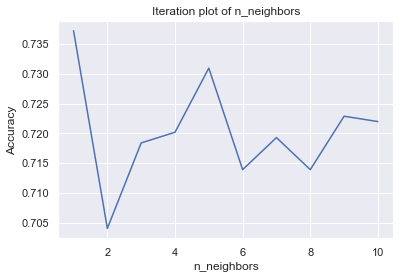

In [178]:
avg_acc_list = []
for i in range(1,11):
    knn = KNeighborsClassifier(n_neighbors=i)
    avg_acc_list.append(np.mean(cross_val_score(knn, X_train, y_train, cv=5)))
    
plt.plot([x for x in range(1,11)], avg_acc_list)
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.title('Iteration plot of n_neighbors')
plt.show()

In [269]:
%%time
knn = KNeighborsClassifier(n_neighbors=5).fit(X_train, y_train)

CPU times: user 7.83 ms, sys: 3.21 ms, total: 11 ms
Wall time: 9.89 ms


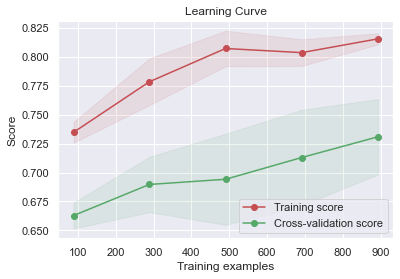

In [329]:
title = 'Learning Curve'
plot = plot_learning_curve(
    knn,
    title,
    X_train,
    y_train,
    axes=None,
    ylim=None,
    cv=5,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
)
plt.grid()
plt.title('Learning Curve')
plot.show()

In [270]:
%%time
out = knn.predict(X_test)

CPU times: user 31.1 ms, sys: 2.49 ms, total: 33.6 ms
Wall time: 32.9 ms


# Model Prediction

In [237]:
def get_metrics(y_true, y_pred):
    metrics = {}
    print('Accuracy:  {:2.2%} '.format(accuracy_score(y_true, y_pred)))
    print('Precision: {:2.2%} '.format(precision_score(y_true, y_pred)))
    print('Recall:    {:2.2%} '.format(recall_score(y_true, y_pred)))
    print('F1 Score:  {:2.2%} '.format(f1_score(y_true, y_pred)))
    print('AUC Score: {:2.2%} '.format(roc_auc_score(y_true, y_pred)))
    
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['F1 Score'] = f1_score(y_true, y_pred)
    metrics['AUC Score'] = roc_auc_score(y_true, y_pred)
    
    return metrics
    

In [256]:
results={}

In [257]:
y_pred = dt.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Decision Tree'] = metrics

Accuracy:  71.13% 
Precision: 71.65% 
Recall:    73.39% 
F1 Score:  72.51% 
AUC Score: 71.04% 


In [258]:
y_pred = mlp.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Neural Network'] = metrics

Accuracy:  74.48% 
Precision: 75.00% 
Recall:    76.21% 
F1 Score:  75.60% 
AUC Score: 74.41% 


In [259]:
y_pred = gbc.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Gradient Boosting Classifier'] = metrics

Accuracy:  78.45% 
Precision: 78.66% 
Recall:    80.24% 
F1 Score:  79.44% 
AUC Score: 78.38% 


In [260]:
y_pred = svm.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['Support Vector Machine'] = metrics

Accuracy:  74.48% 
Precision: 76.25% 
Recall:    73.79% 
F1 Score:  75.00% 
AUC Score: 74.50% 


In [261]:
y_pred = knn.predict(X_test)
metrics = get_metrics(y_test, y_pred)
results['K Nearest Neighbor'] = metrics

Accuracy:  68.62% 
Precision: 67.63% 
Recall:    75.81% 
F1 Score:  71.48% 
AUC Score: 68.34% 


In [262]:
pd.DataFrame(results).T.sort_values('Accuracy', ascending=False)

,Accuracy,Precision,Recall,F1 Score,AUC Score
Gradient Boosting Classifier,0.784519,0.786561,0.802419,0.794411,0.783818
Neural Network,0.744770,0.750000,0.762097,0.756000,0.744092
Support Vector Machine,0.744770,0.762500,0.737903,0.750000,0.745039
Decision Tree,0.711297,0.716535,0.733871,0.725100,0.710414
K Nearest Neighbor,0.686192,0.676259,0.758065,0.714829,0.683380
